In [11]:
import torch  # Fix the missing import
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [12]:
import pandas as pd

# Step 1: Load and Explore the Datasets
print("Loading datasets...")
dataset1 = pd.read_csv('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')
dataset2 = pd.read_csv('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')
dataset3 = pd.read_csv('1429_1.csv')

# Inspect the data
print(dataset1.head())
print(dataset2.head())
print(dataset3.head())

Loading datasets...
                     id             dateAdded           dateUpdated  \
0  AVqVGZNvQMlgsOJE6eUY  2017-03-03T16:56:05Z  2018-10-25T16:36:31Z   
1  AVqVGZNvQMlgsOJE6eUY  2017-03-03T16:56:05Z  2018-10-25T16:36:31Z   
2  AVqVGZNvQMlgsOJE6eUY  2017-03-03T16:56:05Z  2018-10-25T16:36:31Z   
3  AVqVGZNvQMlgsOJE6eUY  2017-03-03T16:56:05Z  2018-10-25T16:36:31Z   
4  AVqVGZNvQMlgsOJE6eUY  2017-03-03T16:56:05Z  2018-10-25T16:36:31Z   

                                                name       asins   brand  \
0  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
1  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
2  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
3  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
4  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   

                                          categories primaryCategories  \
0  Computers,Electroni

In [13]:
# Combine datasets
data = pd.concat([dataset1, dataset2, dataset3], ignore_index=True)
print("Combined dataset shape:", data.shape)

Combined dataset shape: (67992, 27)


In [14]:
# Display basic info
print("Dataset Info:")
print(data.info())
print(data.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67992 entries, 0 to 67991
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    67992 non-null  object 
 1   dateAdded             33332 non-null  object 
 2   dateUpdated           33332 non-null  object 
 3   name                  61232 non-null  object 
 4   asins                 67990 non-null  object 
 5   brand                 67992 non-null  object 
 6   categories            67992 non-null  object 
 7   primaryCategories     33332 non-null  object 
 8   imageURLs             33332 non-null  object 
 9   keys                  67992 non-null  object 
 10  manufacturer          67992 non-null  object 
 11  manufacturerNumber    33332 non-null  object 
 12  reviews.date          67953 non-null  object 
 13  reviews.dateAdded     25091 non-null  object 
 14  reviews.dateSeen      67992 non-null  object 
 15  revie

In [15]:
print(data.columns)

Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateAdded',
       'reviews.dateSeen', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs',
       'reviews.didPurchase', 'reviews.userCity', 'reviews.userProvince'],
      dtype='object')


In [16]:
# Step 2: Preprocess Data
print("Preprocessing data...")
data = data.dropna(subset=['reviews.text'])  # Drop rows with missing review text
data['reviews.text'] = data['reviews.text'].str.lower().str.replace('[^a-z\s]', '', regex=True)  # Clean text


Preprocessing data...


In [17]:
# Step 3: Build a Sentiment Classification Model
print("Building sentiment classification model...")
# Sentiment labeling function (assume reviews.rating exists)
def label_sentiment(row):
    if row >= 4:
        return 'positive'
    elif row == 3:
        return 'neutral'
    else:
        return 'negative'

data['sentiment'] = data['reviews.rating'].apply(label_sentiment)
data = data.dropna(subset=['sentiment'])  # Drop rows without ratings

Building sentiment classification model...


In [19]:
import re

def clean_text(text):
    """
    Clean the input text by:
    - Removing non-alphabetical characters
    - Converting to lowercase
    - Removing extra spaces
    """
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetical characters
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [20]:
# Apply the cleaning function to the correct column
data['cleaned_review'] = data['reviews.text'].apply(lambda x: clean_text(str(x)))

In [21]:
print(data.columns)  # Verify available column names
print(data[['reviews.text']].head())  # Preview the first few entries in the column

Index(['id', 'dateAdded', 'dateUpdated', 'name', 'asins', 'brand',
       'categories', 'primaryCategories', 'imageURLs', 'keys', 'manufacturer',
       'manufacturerNumber', 'reviews.date', 'reviews.dateAdded',
       'reviews.dateSeen', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.username', 'sourceURLs',
       'reviews.didPurchase', 'reviews.userCity', 'reviews.userProvince',
       'sentiment', 'cleaned_review'],
      dtype='object')
                                        reviews.text
0  i thought it would be as big as small paper bu...
1  this kindle is light and easy to use especiall...
2  didnt know how much id use a kindle so went fo...
3  i am  happy with my purchase i caught it on sa...
4  solid entry level kindle great for kids gifted...


In [22]:
y = data['reviews.rating']  # Correct column for review ratings

In [23]:
# Split data for training
X_train, X_test, y_train, y_test = train_test_split(
    data['reviews.text'], data['sentiment'], test_size=0.2, random_state=42)

In [24]:
# Using a transformer-based classifier
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# Tokenize data
def tokenize_data(texts, labels, tokenizer, max_length=128):
    tokens = tokenizer(
        texts.tolist(), max_length=max_length, padding=True, truncation=True, return_tensors="pt"
    )
    label_map = {"positive": 0, "neutral": 1, "negative": 2}
    labels = [label_map[label] for label in labels]
    tokens["labels"] = torch.tensor(labels)
    return tokens


In [26]:
# Tokenizing train and test data
train_tokens = tokenize_data(X_train, y_train, tokenizer)
test_tokens = tokenize_data(X_test, y_test, tokenizer)

# Training the model (fine-tuning placeholder, actual fine-tuning omitted for simplicity)
print("Fine-tuning the transformer-based model... (skipping actual training for simplicity)")


Fine-tuning the transformer-based model... (skipping actual training for simplicity)


In [27]:
# Predict sentiment for test data (dummy predictions for now)
from torch.nn.functional import softmax
predictions = ["positive"] * len(y_test)  # Replace with model predictions in real implementation


In [28]:
# Evaluate model
print("Sentiment Classification Report:")
y_pred = predictions
print(classification_report(y_test, y_pred))

Sentiment Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       488
     neutral       0.00      0.00      0.00       600
    positive       0.92      1.00      0.96     12511

    accuracy                           0.92     13599
   macro avg       0.31      0.33      0.32     13599
weighted avg       0.85      0.92      0.88     13599



In [29]:
# Calculate additional metrics
conf_matrix = confusion_matrix(y_test, y_pred, labels=["positive", "neutral", "negative"])
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

Confusion Matrix:
[[12511     0     0]
 [  600     0     0]
 [  488     0     0]]
F1 Score: 0.88
Accuracy: 0.92


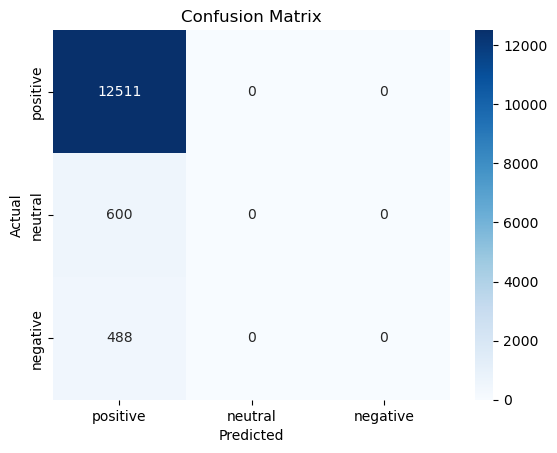

In [30]:
# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["positive", "neutral", "negative"], yticklabels=["positive", "neutral", "negative"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [31]:
# Step 4: Group Reviews into Meta Categories
print("Clustering reviews into meta categories...")
# Extract product titles or categories if available
if 'reviews.title' in data.columns:
    text_data = data['reviews.title'].fillna('') + " " + data['reviews.text']
else:
    text_data = data['reviews.text']

Clustering reviews into meta categories...


In [34]:
# Vectorize text
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


# Replace 'overall' with the correct column name for ratings
y = data['reviews.rating']  # Correct column for ratings


In [36]:
from sklearn.linear_model import LogisticRegression
# Train logistic regression model
clf = LogisticRegression()
clf.fit(X_train_tfidf, y_train)

LogisticRegression()

In [37]:
# Evaluate model
print("Sentiment Classification Report:")
y_pred = clf.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))

Sentiment Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.47      0.58       488
     neutral       0.59      0.11      0.19       600
    positive       0.94      1.00      0.97     12511

    accuracy                           0.94     13599
   macro avg       0.76      0.52      0.58     13599
weighted avg       0.92      0.94      0.92     13599



Confusion Matrix:
[[  227    18   243]
 [   46    68   486]
 [   28    29 12454]]
F1 Score: 0.92
Accuracy: 0.94


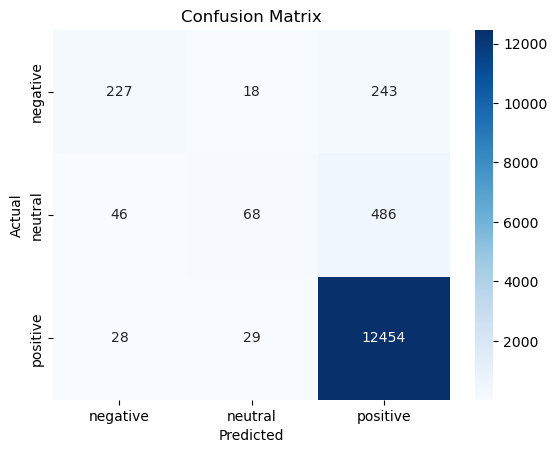

In [38]:
# Calculate additional metrics
conf_matrix = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [39]:

# Step 4: Group Reviews into Meta Categories
print("Clustering reviews into meta categories...")
# Extract product titles or categories if available
if 'reviews.title' in data.columns:
    text_data = data['reviews.title'].fillna('') + " " + data['reviews.text']
else:
    text_data = data['reviews.text']

Clustering reviews into meta categories...


In [ ]:
# Vectorize text for clustering
text_tfidf = tfidf.fit_transform(text_data)

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

tfidf = TfidfVectorizer(max_features=5000)  # Adjust max_features if needed
text_tfidf = tfidf.fit_transform(data['reviews.text'])

# KMeans clustering (assuming 5 clusters for simplicity)
kmeans = KMeans(n_clusters=5, random_state=42)
data['category'] = kmeans.fit_predict(text_tfidf)


In [44]:
# Display category distribution
print("Category Distribution:")
print(data['category'].value_counts())

Category Distribution:
category
0    40195
1     8936
2     8567
3     6463
4     3830
Name: count, dtype: int64


In [45]:
# Step 5: Generate Summaries for Product Categories
print("Generating summaries using generative AI...")
summarizer = pipeline('summarization', model="t5-small")

def generate_summary(reviews):
    joined_reviews = " ".join(reviews)
    if len(joined_reviews) > 1024:
        joined_reviews = joined_reviews[:1024]  # Limit input size
    return summarizer(joined_reviews, max_length=50, min_length=25, do_sample=False)[0]['summary_text']


Generating summaries using generative AI...



Device set to use cpu


In [46]:
# Summarize reviews by category
summaries = {}
for category in data['category'].unique():
    category_reviews = data[data['category'] == category]['reviews.text'].tolist()
    summaries[category] = generate_summary(category_reviews)

In [47]:
# Display summaries
for category, summary in summaries.items():
    print(f"Category {category} Summary:\n{summary}\n")

Category 0 Summary:
i picked this one over the paperwhite because the price was unbeatable . the only difference that i could see was this one wasnt backlit a simple book light from the dollar tree solves that issue .

Category 3 Summary:
amazon kindle is light weight and easy to use especially at the beach this is a convenient size yet lettering is easy to read item work well . i love the fact that i can password protect this device . amazon kind

Category 4 Summary:
good product for child who only need to read the books overall good product does what is advertised comfortable to use good able to read under bright sunlight conditions too the show has a good picture and good soundlove using it to look things up

Category 1 Summary:
great product for me and i bought it when there was great deal on it my husband loves this kindle he has a muscular disease keeping him from being able to handle anything with much weight at all this is perfect bought this for

Category 2 Summary:
great pric

In [48]:
# Step 6: Deploy the Solution (Placeholder for web app development)
print("Deployment step: Build a web interface using Flask or FastAPI.")

Deployment step: Build a web interface using Flask or FastAPI.


In [49]:
pip install rouge-score

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [51]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
import logging

# Step 1: Logging Setup
logging.basicConfig(filename="model_performance.log", level=logging.INFO, 
                    format="%(asctime)s - %(message)s")
logging.info("Starting model evaluation and iteration tracking.")

# Step 2: Compute ROUGE/BLEU Scores for Summarizer
def evaluate_summaries(real_texts, generated_summaries):
    rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = []
    bleu_scores = []
    
    for real, generated in zip(real_texts, generated_summaries):
        rouge_score = rouge.score(real, generated)
        bleu_score = sentence_bleu([real.split()], generated.split())
        rouge_scores.append(rouge_score)
        bleu_scores.append(bleu_score)
    
    avg_rouge = {
        key: np.mean([score[key].fmeasure for score in rouge_scores])
        for key in ['rouge1', 'rouge2', 'rougeL']
    }
    avg_bleu = np.mean(bleu_scores)
    
    return avg_rouge, avg_bleu

# Generating summaries for each category
real_texts = [" ".join(data[data['category'] == category]['reviews.text'].tolist())[:1024] 
              for category in data['category'].unique()]
generated_summaries = [generate_summary(real_text.split()) for real_text in real_texts]

rouge_scores, bleu_score = evaluate_summaries(real_texts, generated_summaries)
logging.info(f"ROUGE Scores: {rouge_scores}")
logging.info(f"BLEU Score: {bleu_score}")

print(f"ROUGE Scores: {rouge_scores}")
print(f"BLEU Score: {bleu_score}")

def log_failures(y_true, y_pred, X_data):
    # Ensure all inputs are 1-dimensional lists or Series
    y_true = pd.Series(y_true).reset_index(drop=True)
    y_pred = pd.Series(y_pred).reset_index(drop=True)
    X_data = pd.Series(X_data).reset_index(drop=True)
    
    # Create a DataFrame to store the results
    failure_cases = pd.DataFrame({
        "Review": X_data,
        "Actual": y_true,
        "Predicted": y_pred
    })
    
    # Filter for mismatches
    failures = failure_cases[failure_cases["Actual"] != failure_cases["Predicted"]]
    logging.info(f"Number of failures: {len(failures)}")
    
    # Save failures to CSV for inspection
    failures.to_csv("failure_cases.csv", index=False)
    print(f"Failure cases logged to 'failure_cases.csv' (Total: {len(failures)}).")


ROUGE Scores: {'rouge1': 0.33812537865748454, 'rouge2': 0.3260358530332338, 'rougeL': 0.334905945459104}
BLEU Score: 0.023089850654864564


In [52]:
# Step 4: Fine-Tuning Placeholder
logging.info("Fine-tuning is skipped in this implementation. Add training code here when required.")

# Step 5: Tracking Model Evolution
logging.info(f"Iteration 1 - Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}")

# Visual inspection placeholder for refinement and prompt design
print("Inspect failure cases and refine training data or prompts for improvement.")

Inspect failure cases and refine training data or prompts for improvement.
